In [2]:
%config InlineBackend.figure_formats = ['svg']
from quimb.tensor import *
from quimb import *
from quimb.gates import *
import numpy as np
import random
import quimb as qu
import quimb.tensor as qtn
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_clifford
from tqdm import tqdm
from quimb.tensor.tensor_1d_compress import tensor_network_1d_compress_zipup as zipup
import itertools
import matplotlib.colors as mcolors

In [9]:
L = 6                 # number of qubits
D = 18                # number of layers
n_runs = 100            # number of independent circuit realizations to average over
p_M = [0, 0.1, 0.2, 0.5, 1]  # measurement probability per qubit per layer, will compare all probs in list
colors = itertools.cycle(list(mcolors.CSS4_COLORS.keys()))
rng = np.random.default_rng(None) # random float in [0, 1), replace None with seed (1234) for reproducability

In [4]:
def ipr_4(state):
    # calculate IPR via, takes circ
    psi = state.psi
    ipr_tn = (psi.H & psi & psi.H & psi)
    # 4-copy contraction
    ipr_val = ipr_tn.contract(output_inds=())
    return float(ipr_val)

def ipr(state):
    # calculate IPR from dense statevector or circuit-like objects
    if hasattr(state, 'psi') and hasattr(state.psi, 'to_dense'):
        dense = state.psi.to_dense(optimize='auto')
    elif hasattr(state, 'to_dense'):
        dense = state.to_dense(optimize='auto')
    else:
        dense = np.asarray(state)
    norm = np.linalg.norm(dense)
    if not np.isclose(norm, 1.0):
        dense = dense / norm
    return np.sum(np.abs(dense) ** 4)

def pentropy(ipr):
    # calculate participation entropy from IPR
    return -np.log(ipr)

def ising(J):
    """Two-site Ising ZZ interaction e^{-i J Z⊗Z}."""
    ZZ = np.kron(qu.pauli('Z'), qu.pauli('Z'))
    return qu.expm(-1j * J * ZZ).reshape(2, 2, 2, 2)

def kick(h):
    """Single-site transverse field kick e^{-i h X}."""
    return qu.expm(-1j * h * qu.pauli('X')).reshape(2, 2)



In [5]:
def z_measure(circ, L, pM, rng, round_int):
    """
    Apply Z-basis measurements to each qubit in a circuit with probability pM.
    """
    dense = circ.psi.to_dense()
    norm = np.linalg.norm(dense)
    if not np.isclose(norm, 1.0):
        dense /= norm
    outcomes = {}

    for q in range(L):
        if rng.random() < pM:
            Z = qu.pauli('Z')
            A = qu.ikron(Z, [2] * L, q)          # Z acting on qubit q
            result, dense = qu.measure(dense, A) # collapses + renormalizes
            outcomes[q] = result
            # circ.add_tag(f"MEAS_q{q}_layer{layer_idx}") (need to fix this)
    
    state = qtn.MatrixProductState.from_dense(dense)

    return state, dense, outcomes


In [10]:
iprs_avg_dict = {}     # to store averaged IPRs
entropies_avg_dict = {}  # to store averaged entropies
circuits = {}          # save circuits to draw
J = np.pi / 4
h = np.pi / 4

for pM in p_M:  # only loop over measurement probs
    iprs_avg = np.zeros(D + 1)
    entropies_avg = np.zeros(D + 1)

    for run in tqdm(range(n_runs), desc=f"Running pM={pM}", leave=True, ncols=80):
        circ = qtn.CircuitMPS(N=L, max_bond=1024, cutoff=1e-3)
        iprs, entropies = [], []

        ipr0 = ipr(circ)  # should be 1
        iprs.append(ipr0)
        entropies.append(pentropy(ipr0))

        for r in range(D):
            # --- Ising ZZ interactions in brickwork pattern ---
            if r % 2 == 0:
                for i in range(0, L - 1, 2):
                    circ.apply_gate(ising(J), i, i + 1,
                                    gate_round=r, tags=('ZZ', f'layer{r}'))
            else:
                for i in range(1, L - 1, 2):
                    circ.apply_gate(ising(J), i, i + 1,
                                    gate_round=r, tags=('ZZ', f'layer{r}'))

            # --- Single-qubit kicks (no randomness here, all applied) ---
            for q in range(L):
                circ.apply_gate(kick(h), q,
                                gate_round=r, tags=('kick', f'layer{r}'))

            # --- Measurement with prob pM ---
            state, dense, outcomes = z_measure(circ, L, pM, rng, round_int=r)

            ipr_n = ipr(dense)
            iprs.append(ipr_n)
            entropies.append(pentropy(ipr_n))

            # update circuit with collapsed state
            circ._psi = state
            circ._maybe_convert(circ.psi)

        iprs_avg += np.array(iprs)
        entropies_avg += np.array(entropies)

    # average over runs
    iprs_avg /= n_runs
    entropies_avg /= n_runs

    # store using scalar key pM
    iprs_avg_dict[pM] = iprs_avg
    entropies_avg_dict[pM] = entropies_avg
    circuits[pM] = circ

Running pM=1: 100%|███████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


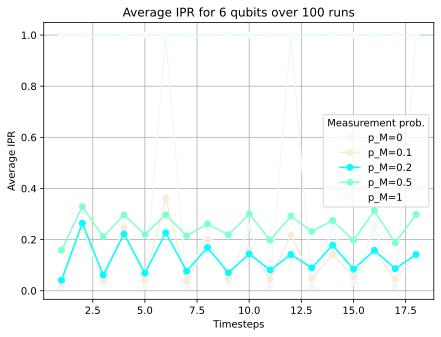

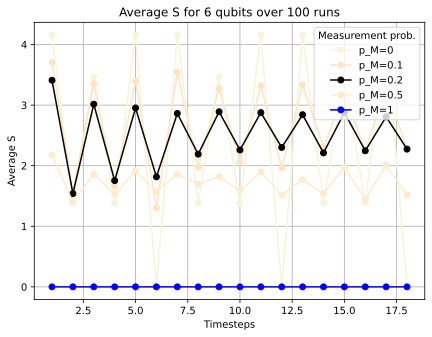

In [11]:
# Plot IPR
plt.figure(figsize=(7, 5))
for pM, color in zip(p_M, colors):
    xi = range(1, D + 1)
    yi = iprs_avg_dict[pM][1:]  # skip t=0
    plt.plot(xi, yi, marker='o', color=color, label=f"p_M={pM}")

#plt.yscale('log')
plt.xlabel("Timesteps")
plt.ylabel("Average IPR")
plt.title(f"Average IPR for {L} qubits over {n_runs} runs")
plt.grid(True)
plt.legend(title="Measurement prob.")
plt.show()

# Plot S
plt.figure(figsize=(7, 5))
for pM, color in zip(p_M, colors):
    xs = range(1, D + 1)
    ys = entropies_avg_dict[pM][1:]  # skip t=0
    plt.plot(xs, ys, marker='o', color=color, label=f"p_M={pM}")

#plt.yscale('log')
plt.xlabel("Timesteps")
plt.ylabel("Average S")
plt.title(f"Average S for {L} qubits over {n_runs} runs")
plt.grid(True)
plt.legend(title="Measurement prob.")
plt.show()
